# Diffusion vs FlowMatching

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*6bH8ZTgPbeo9Lhs_-tUKCQ.png" alt="Your image title" width=50% height=50%/>


### Reference :
- ***Blogs***:
    - [Flow Matching vs Diffusion](https://harshm121.medium.com/flow-matching-vs-diffusion-79578a16c510)
- ***Github***:
    - https://github.com/harshm121/Diffusion-v-FlowMatching/


----

### Conda env : [cv_playgrounds](../../README.md#setup-a-conda-environment)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.animation as animation
from IPython.display import HTML
# import typer

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

from pathlib import Path

Path("./temp/diffusion_flowmatching/").mkdir(exist_ok=True, parents= True)


## PART 1: SHARED COMPONENTS

In [ ]:
# ======================================================
# PART 1: SHARED COMPONENTS
# ======================================================

class SimpleMLP(nn.Module):
    """Simple MLP that can be used for both diffusion and flow matching"""
    def __init__(self, input_dim, hidden_dims, output_dim, time_embedding_dim=32):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embedding_dim),
            nn.SiLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim),
            nn.SiLU()
        )

        # Input layer
        layers = [nn.Linear(input_dim + time_embedding_dim, hidden_dims[0]), nn.SiLU()]

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.SiLU())

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        # Embed time
        t_embed = self.time_embed(t.unsqueeze(-1))

        # Concatenate input and time embedding
        x_t = torch.cat([x, t_embed], dim=-1)

        # Pass through the network
        return self.net(x_t)

def create_toy_data(n_samples=5000, data_dim=2):
    """Create a toy dataset of a 2D Gaussian mixture"""
    n_per_cluster = n_samples // 3

    # Create three clusters
    cluster1 = torch.randn(n_per_cluster, data_dim) * 0.3 + torch.tensor([2.0, 2.0])
    cluster2 = torch.randn(n_per_cluster, data_dim) * 0.3 + torch.tensor([-2.0, 2.0])
    cluster3 = torch.randn(n_per_cluster, data_dim) * 0.3 + torch.tensor([0.0, -2.0])

    # Combine clusters
    data = torch.cat([cluster1, cluster2, cluster3], dim=0)

    return data

def plot_samples(real_samples, generated_samples, title="Sample Comparison"):
    """Plot real and generated samples"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(real_samples[:, 0].cpu(), real_samples[:, 1].cpu(), alpha=0.5)
    plt.title("Real Data")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

    plt.subplot(1, 2, 2)
    plt.scatter(generated_samples[:, 0].cpu(), generated_samples[:, 1].cpu(), alpha=0.5)
    plt.title("Generated Data")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

    plt.suptitle(title)
    plt.tight_layout()
    # plt.savefig(f"{title}.png")
    plt.show()




## PART 2: DIFFUSION MODEL IMPLEMENTATION

In [ ]:
# ======================================================
# PART 2: DIFFUSION MODEL IMPLEMENTATION
# ======================================================

class DiffusionModel:
    def __init__(self, data_dim, hidden_dims=[128, 256, 128], device="cuda" if torch.cuda.is_available() else "cpu"):
        self.data_dim = data_dim
        self.device = device

        # Create model that predicts noise
        self.model = SimpleMLP(data_dim, hidden_dims, data_dim).to(device)

        # Define diffusion hyperparameters
        self.n_timesteps = 1000
        self.beta_min = 1e-4
        self.beta_max = 0.02

        # Create noise schedule
        self.betas = torch.linspace(self.beta_min, self.beta_max, self.n_timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alphas_cumprod[:-1]])
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1 / self.alphas)
        self.posterior_variance = self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

    def q_sample(self, x_0, t, noise=None):
        """Forward diffusion process: add noise to data according to timestep t"""
        if noise is None:
            noise = torch.randn_like(x_0)

        # Extract coefficients for the specific timesteps
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        # Add noise according to schedule
        return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

    def p_sample(self, x_t, t):
        """Single step of reverse diffusion process (denoising)"""
        # Model predicts noise
        predicted_noise = self.model(x_t, t / self.n_timesteps)

        # Extract coefficients for specific timestep
        alpha = extract(self.alphas, t, x_t.shape)
        alpha_cumprod = extract(self.alphas_cumprod, t, x_t.shape)
        beta = extract(self.betas, t, x_t.shape)
        sqrt_recip_alpha = extract(self.sqrt_recip_alphas, t, x_t.shape)

        # No noise when t=0
        noise = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)

        # Compute mean for the reverse process
        mean = sqrt_recip_alpha * (x_t - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)

        # Compute variance
        variance = extract(self.posterior_variance, t, x_t.shape)

        return mean + torch.sqrt(variance) * noise

    def p_sample_loop(self, n_samples):
        """Generate samples by iterative denoising from pure noise"""
        device = self.device
        shape = (n_samples, self.data_dim)

        # Start from pure noise
        x = torch.randn(shape, device=device)

        # Iteratively denoise
        with torch.no_grad():
            for t in tqdm(reversed(range(self.n_timesteps)), desc="Sampling"):
                t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
                x = self.p_sample(x, t_batch)

        return x

    def train_step(self, x_0, optimizer):
        """Single training step for diffusion model"""
        batch_size = x_0.shape[0]

        # Sample random timesteps
        t = torch.randint(0, self.n_timesteps, (batch_size,), device=self.device, dtype=torch.long)

        # Add noise to data
        x_t, noise = self.q_sample(x_0, t)

        # Predict noise
        predicted_noise = self.model(x_t, t / self.n_timesteps)

        # Compute loss
        loss = F.mse_loss(noise, predicted_noise)

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def train(self, dataloader, n_epochs, lr=1e-4):
        """Train the diffusion model"""
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        for epoch in range(n_epochs):
            epoch_loss = 0.0
            for x_batch in dataloader:
                x_batch = x_batch[0].to(self.device)  # Move data to device
                loss = self.train_step(x_batch, optimizer)
                epoch_loss += loss

            avg_loss = epoch_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{n_epochs} - Avg Loss: {avg_loss:.6f}")

def extract(coefficients, t, x_shape):
    """Extract coefficients for specific timesteps and reshape to match data"""
    batch_size = t.shape[0]
    out = coefficients.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))



## PART 3: FLOW MATCHING IMPLEMENTATION

In [ ]:
# ======================================================
# PART 3: FLOW MATCHING IMPLEMENTATION
# ======================================================

class FlowMatching:
    def __init__(self, data_dim, hidden_dims=[128, 256, 128], device="cuda" if torch.cuda.is_available() else "cpu"):
        self.data_dim = data_dim
        self.device = device

        # Create model that predicts velocity vectors
        self.model = SimpleMLP(data_dim, hidden_dims, data_dim).to(device)

        # Sigma for path noise (can be a function of t)
        self.sigma = 0.1

    def sample_path_point(self, x_0, z, t):
        """Sample point along the path from noise z to data x_0 at time t"""
        # Linear interpolation path with small noise
        noise = torch.randn_like(x_0) * self.sigma
        x_t = (1 - t) * z + t * x_0 + noise * torch.sqrt(t * (1 - t))

        # Target velocity for the path
        # For straight-line path (excluding the noise term for simplicity)
        target_v = x_0 - z

        return x_t, target_v

    def train_step(self, x_0, optimizer):
        """Single training step for flow matching"""
        batch_size = x_0.shape[0]

        # Sample random timesteps
        t = torch.rand(batch_size, device=self.device)

        # Sample noise points
        z = torch.randn_like(x_0)

        # Get path points and target velocities
        x_t, target_v = self.sample_path_point(x_0, z, t.unsqueeze(-1))

        # Predict velocity vectors
        predicted_v = self.model(x_t, t)

        # Compute loss
        loss = F.mse_loss(predicted_v, target_v)

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def train(self, dataloader, n_epochs, lr=1e-4):
        """Train the flow matching model"""
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        for epoch in range(n_epochs):
            epoch_loss = 0.0
            for x_batch in dataloader:
                x_batch = x_batch[0].to(self.device)  # Move data to device
                loss = self.train_step(x_batch, optimizer)
                epoch_loss += loss

            avg_loss = epoch_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{n_epochs} - Avg Loss: {avg_loss:.6f}")

    def euler_sample(self, n_samples, n_steps=100):
        """Generate samples using Euler method to solve the ODE"""
        device = self.device
        shape = (n_samples, self.data_dim)

        # Start from noise distribution
        x = torch.randn(shape, device=device)

        # Step size
        dt = 1.0 / n_steps

        # Solve ODE
        with torch.no_grad():
            for i in tqdm(range(n_steps), desc="Sampling"):
                t = torch.ones(n_samples, device=device) * i * dt
                v = self.model(x, t)
                x = x + v * dt

        return x

    def heun_sample(self, n_samples, n_steps=50):
        """Generate samples using Heun's method (2nd order) to solve the ODE"""
        device = self.device
        shape = (n_samples, self.data_dim)

        # Start from noise distribution
        x = torch.randn(shape, device=device)

        # Step size
        dt = 1.0 / n_steps

        # Solve ODE with Heun's method
        with torch.no_grad():
            for i in tqdm(range(n_steps), desc="Sampling"):
                t = torch.ones(n_samples, device=device) * i * dt

                # First step (Euler)
                v1 = self.model(x, t)
                x_euler = x + v1 * dt

                # Second step (correction)
                t_next = torch.ones(n_samples, device=device) * (i + 1) * dt
                v2 = self.model(x_euler, t_next)

                # Heun's update
                x = x + 0.5 * dt * (v1 + v2)

        return x



## PART 4: VISUALIZATION ENHANCEMENTS

In [ ]:
# ======================================================
# PART 4: VISUALIZATION ENHANCEMENTS
# ======================================================

def plot_trajectory(model, n_points=5, n_steps=50, mode="diffusion"):
    """Visualize the trajectory of generation process"""
    device = model.device
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

    # Initialize points
    x = torch.randn(n_points, 2).to(device)
    trajectories = [x.cpu().numpy()]

    with torch.no_grad():
        if mode == "diffusion":
            # For diffusion model, we reverse from T to 0
            for t in reversed(range(model.n_timesteps)):
                t_batch = torch.full((n_points,), t, device=device, dtype=torch.long)
                x = model.p_sample(x, t_batch)
                if t % (model.n_timesteps // n_steps) == 0:
                    trajectories.append(x.cpu().numpy())
        else:
            # For flow matching, we go from 0 to 1
            dt = 1.0 / n_steps
            for i in range(n_steps):
                t = torch.ones(n_points, device=device) * i * dt
                v = model.model(x, t)
                x = x + v * dt
                trajectories.append(x.cpu().numpy())

    # Plot trajectories
    colors = plt.cm.rainbow(np.linspace(0, 1, n_points))
    for i in range(n_points):
        path = np.array([traj[i] for traj in trajectories])
        ax.plot(path[:, 0], path[:, 1], 'o-', color=colors[i], alpha=0.7, markersize=3)
        # Mark start and end
        ax.plot(path[0, 0], path[0, 1], 'o', color=colors[i], markersize=6)
        ax.plot(path[-1, 0], path[-1, 1], '*', color=colors[i], markersize=10)

    ax.set_title(f'{mode.capitalize()} Trajectory Visualization')
    ax.grid(alpha=0.3)
    # plt.savefig(f"{mode}_trajectory.png")
    plt.show()

def visualize_intermediate_steps(model, n_samples=500, n_snapshots=5, mode="diffusion"):
    """Visualize intermediate steps of the generative process"""
    device = model.device
    fig, axes = plt.subplots(1, n_snapshots, figsize=(15, 4))

    # Initialize points
    x = torch.randn(n_samples, 2).to(device)
    snapshots = []

    with torch.no_grad():
        if mode == "diffusion":
            # For diffusion, calculate evenly spaced timesteps from T to 0
            timesteps = np.linspace(model.n_timesteps-1, 0, n_snapshots).astype(int)
            current_x = x.clone()

            # Process all timesteps
            for t in tqdm(reversed(range(model.n_timesteps)), desc="Generating diffusion snapshots"):
                t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
                current_x = model.p_sample(current_x, t_batch)

                # Save snapshot if this timestep is in our target timesteps
                if t in timesteps:
                    snapshots.append(current_x.cpu().numpy())
        else:
            # For flow matching
            n_steps = 50
            dt = 1.0 / n_steps
            step_size = n_steps // (n_snapshots-1)  # Adjust for even spacing

            current_x = x.clone()
            snapshots.append(current_x.cpu().numpy())  # First snapshot is noise

            for i in tqdm(range(n_steps), desc="Generating flow matching snapshots"):
                t = torch.ones(n_samples, device=device) * i * dt
                v = model.model(current_x, t)
                current_x = current_x + v * dt

                # Take snapshots at regular intervals
                if i == n_steps-1 or i % step_size == 0:
                    if len(snapshots) < n_snapshots:
                        snapshots.append(current_x.cpu().numpy())

    # Plot snapshots
    if mode == "diffusion":
        titles = [f"t={t}" for t in timesteps]
    else:
        titles = [f"t={i/(n_snapshots-1):.2f}" for i in range(n_snapshots)]

    for i, (ax, snapshot, title) in enumerate(zip(axes, snapshots, titles)):
        ax.scatter(snapshot[:, 0], snapshot[:, 1], alpha=0.5, s=10)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_title(title)
        ax.grid(alpha=0.3)

    plt.suptitle(f"{mode.capitalize()} Generation Process")
    plt.tight_layout()
    # plt.savefig(f"{mode}_intermediate_steps.png")
    plt.show()

def animate_generation(model, n_samples=200, n_frames=50, mode="diffusion", interval=100):
    """Create animation of the generation process"""
    device = model.device
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.close()  # Don't display the empty figure

    # Initialize points
    x = torch.randn(n_samples, 2).to(device)
    frames = []

    with torch.no_grad():
        if mode == "diffusion":
            # For diffusion, take frames at regular intervals
            step_size = model.n_timesteps // n_frames
            frames.append(x.cpu().numpy())  # Initial noise

            # Need to collect all timestamps to sample at first
            timesteps = list(reversed(range(0, model.n_timesteps)))
            sampled_timesteps = []

            # Generate the complete trajectory
            current_x = x.clone()
            for t in tqdm(timesteps, desc="Generating diffusion frames"):
                t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
                current_x = model.p_sample(current_x, t_batch)

                # Save frame at regular intervals
                if t % step_size == 0 or t == 0:  # Make sure to include t=0 (final result)
                    frames.append(current_x.cpu().numpy())
                    sampled_timesteps.append(t)
        else:
            # For flow matching
            n_steps = 50
            dt = 1.0 / n_steps

            current_x = x.clone()
            frames.append(current_x.cpu().numpy())

            for i in tqdm(range(n_steps), desc="Generating flow matching frames"):
                t = torch.ones(n_samples, device=device) * i * dt
                v = model.model(current_x, t)
                current_x = current_x + v * dt
                if i % (n_steps // n_frames) == 0 or i == n_steps-1:  # Make sure to include final result
                    frames.append(current_x.cpu().numpy())

    # Create animation
    scatter = ax.scatter([], [], alpha=0.6)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.grid(alpha=0.3)
    title = ax.set_title("")

    def init():
        scatter.set_offsets(np.zeros((0, 2)))
        title.set_text("")
        return scatter, title

    def update(frame_idx):
        scatter.set_offsets(frames[frame_idx])
        if mode == "diffusion":
            if frame_idx == 0:
                t_val = model.n_timesteps
            else:
                t_val = sampled_timesteps[frame_idx-1]  # Use the actual saved timestep
            title.set_text(f"Diffusion: t = {t_val}")
        else:
            t_val = min(1.0, (frame_idx * n_steps) / (n_frames * n_steps))
            title.set_text(f"Flow Matching: t = {t_val:.2f}")
        return scatter, title

    anim = animation.FuncAnimation(fig, update, frames=len(frames),
                                   init_func=init, blit=True, interval=interval)

    # Save animation
    anim.save(f"./temp/diffusion_flowmatching/diffusion_flowmatching/{mode}_generation.gif", writer='pillow', fps=10)

    return HTML(anim.to_jshtml())

def plot_vector_field(model, n_grid=20, mode="diffusion", timestep=0.5):
    """Plot the vector field predicted by the model"""
    device = model.device

    # Create grid of points
    x = np.linspace(-4, 4, n_grid)
    y = np.linspace(-4, 4, n_grid)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X.flatten(), Y.flatten()], axis=1)

    # Convert to torch
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

    with torch.no_grad():
        if mode == "diffusion":
            # For diffusion, we visualize the predicted noise
            t = int(timestep * model.n_timesteps)
            t_batch = torch.full((grid_tensor.shape[0],), t, device=device, dtype=torch.long)
            vectors = -model.model(grid_tensor, t_batch / model.n_timesteps)
        else:
            # For flow matching, we visualize the predicted velocity
            t_batch = torch.full((grid_tensor.shape[0],), timestep, device=device, dtype=torch.float32)
            vectors = model.model(grid_tensor, t_batch)

    # Convert back to numpy
    vectors = vectors.cpu().numpy()

    # Normalize for visualization
    lengths = np.sqrt(vectors[:, 0]**2 + vectors[:, 1]**2)
    max_len = np.percentile(lengths, 90)  # Use 90th percentile to avoid outliers
    vectors = vectors / max_len

    # Plot
    plt.figure(figsize=(8, 8))
    plt.quiver(grid_points[:, 0], grid_points[:, 1],
               vectors[:, 0], vectors[:, 1],
               angles='xy', scale_units='xy', scale=1,
               color='blue', alpha=0.7)

    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.grid(alpha=0.3)

    if mode == "diffusion":
        title = f"Diffusion Model: Vector Field at t={t}/{model.n_timesteps}"
    else:
        title = f"Flow Matching: Vector Field at t={timestep:.2f}"

    plt.title(title)
    # plt.savefig(f"{mode}_vector_field_t{timestep}.png")
    plt.show()

def compare_training_dynamics():
    """Compare training dynamics between diffusion and flow matching"""
    # Create shared toy dataset
    data = create_toy_data(n_samples=5000, data_dim=2)
    dataloader = DataLoader(TensorDataset(data), batch_size=128, shuffle=True)

    # Create models
    diffusion = DiffusionModel(data_dim=2, hidden_dims=[64, 128, 64])
    flow = FlowMatching(data_dim=2, hidden_dims=[64, 128, 64])

    # Training settings
    n_epochs = 50
    diffusion_losses = []
    flow_losses = []

    # Train both models and record losses
    for epoch in range(n_epochs):
        # Diffusion training
        diffusion_epoch_loss = 0.0
        for x_batch in dataloader:
            x_batch = x_batch[0].to(diffusion.device)
            loss = diffusion.train_step(x_batch, optim.Adam(diffusion.model.parameters(), lr=1e-4))
            diffusion_epoch_loss += loss
        diffusion_losses.append(diffusion_epoch_loss / len(dataloader))

        # Flow matching training
        flow_epoch_loss = 0.0
        for x_batch in dataloader:
            x_batch = x_batch[0].to(flow.device)
            loss = flow.train_step(x_batch, optim.Adam(flow.model.parameters(), lr=1e-4))
            flow_epoch_loss += loss
        flow_losses.append(flow_epoch_loss / len(dataloader))

        print(f"Epoch {epoch+1}/{n_epochs} - Diffusion Loss: {diffusion_losses[-1]:.6f}, Flow Loss: {flow_losses[-1]:.6f}")

    # Plot loss comparison
    plt.figure(figsize=(10, 6))
    plt.plot(diffusion_losses, label='Diffusion', marker='o', alpha=0.7)
    plt.plot(flow_losses, label='Flow Matching', marker='s', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    # plt.savefig("training_dynamics_comparison.png")
    plt.show()

    return diffusion, flow



In [ ]:
# ======================================================
# PART 5: DEMONSTRATIONS
# ======================================================

def run_diffusion_demo(n_epochs: int = 50, batch_size: int = 128, n_samples: int = 1000):
    """Run enhanced demonstration of diffusion model with visualizations"""
    print("=== DIFFUSION MODEL DEMONSTRATION ===")

    # Create toy dataset
    data = create_toy_data(n_samples=5000, data_dim=2)
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=True)

    # Initialize and train diffusion model
    diffusion = DiffusionModel(data_dim=2, hidden_dims=[128, 256, 128])
    diffusion.train(dataloader, n_epochs=n_epochs)

    # Generate samples
    generated_samples = diffusion.p_sample_loop(n_samples=n_samples)

    # Basic comparison plot
    plot_samples(data, generated_samples, title="Diffusion Model: Real vs Generated")

    # Enhanced visualizations
    plot_trajectory(diffusion, n_points=8, mode="diffusion")
    visualize_intermediate_steps(diffusion, n_samples=500, mode="diffusion")
    plot_vector_field(diffusion, mode="diffusion", timestep=0.5)
    plot_vector_field(diffusion, mode="diffusion", timestep=0.9)

    animate_generation(diffusion, mode="diffusion")
    return diffusion

def run_flow_matching_demo(n_epochs: int = 50, batch_size: int = 128, n_samples: int = 1000):
    """Run enhanced demonstration of flow matching model with visualizations"""
    print("\n=== FLOW MATCHING DEMONSTRATION ===")

    # Create toy dataset
    data = create_toy_data(n_samples=5000, data_dim=2)
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=True)

    # Initialize and train flow matching model
    flow = FlowMatching(data_dim=2, hidden_dims=[128, 256, 128])
    flow.train(dataloader, n_epochs=n_epochs)

    # Generate samples
    generated_samples = flow.heun_sample(n_samples=n_samples, n_steps=50)

    # Basic comparison plot
    plot_samples(data, generated_samples, title="Flow Matching: Real vs Generated")

    # Enhanced visualizations
    plot_trajectory(flow, n_points=8, mode="flow")
    visualize_intermediate_steps(flow, n_samples=500, mode="flow")
    plot_vector_field(flow, mode="flow", timestep=0.1)
    plot_vector_field(flow, mode="flow", timestep=0.5)

    animate_generation(flow, mode="flow")
    return flow

def create_comparison_animation(diffusion_model, flow_model, n_samples=200, n_frames=50, interval=100):
    """Create a side-by-side animation comparing diffusion, flow matching, and real data"""
    device = diffusion_model.device
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    plt.close()  # Don't display the empty figure

    # Initialize points and create real data
    x_diffusion = torch.randn(n_samples, 2).to(device)
    x_flow = torch.randn(n_samples, 2).to(device)
    real_data = create_toy_data(n_samples=n_samples).to(device)

    # Storage for animation frames
    diffusion_frames = []
    flow_frames = []

    # Generate diffusion frames
    with torch.no_grad():
        # For diffusion
        step_size = diffusion_model.n_timesteps // n_frames
        diffusion_frames.append(x_diffusion.cpu().numpy())
        current_x = x_diffusion.clone()
        sampled_timesteps = []

        for t in tqdm(reversed(range(diffusion_model.n_timesteps)), desc="Generating diffusion frames"):
            t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
            current_x = diffusion_model.p_sample(current_x, t_batch)

            if t % step_size == 0 or t == 0:
                diffusion_frames.append(current_x.cpu().numpy())
                sampled_timesteps.append(t)

        # For flow matching
        n_steps = 50
        dt = 1.0 / n_steps
        current_x = x_flow.clone()
        flow_frames.append(current_x.cpu().numpy())

        for i in tqdm(range(n_steps), desc="Generating flow matching frames"):
            t = torch.ones(n_samples, device=device) * i * dt
            v = flow_model.model(current_x, t)
            current_x = current_x + v * dt
            if i % (n_steps // n_frames) == 0 or i == n_steps-1:
                flow_frames.append(current_x.cpu().numpy())

    # Create scatter plots
    scatter_diff = ax1.scatter([], [], alpha=0.6)
    scatter_flow = ax2.scatter([], [], alpha=0.6)
    scatter_real = ax3.scatter(real_data[:, 0].cpu(), real_data[:, 1].cpu(), alpha=0.6)

    # Set consistent axes limits and titles
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.grid(alpha=0.3)

    ax3.set_title("Real Data")

    def init():
        scatter_diff.set_offsets(np.zeros((0, 2)))
        scatter_flow.set_offsets(np.zeros((0, 2)))
        return scatter_diff, scatter_flow, scatter_real

    def update(frame_idx):
        # Update diffusion plot
        scatter_diff.set_offsets(diffusion_frames[frame_idx])
        if frame_idx == 0:
            t_val_diff = 0.0
        else:
            # Normalize timestep to [0,1]
            t_val_diff = 1 - sampled_timesteps[frame_idx-1] / diffusion_model.n_timesteps
        ax1.set_title(f"Diffusion: t = {t_val_diff:.2f}")

        # Update flow matching plot
        scatter_flow.set_offsets(flow_frames[frame_idx])
        t_val_flow = min(1.0, (frame_idx * n_steps) / (n_frames * n_steps))
        ax2.set_title(f"Flow Matching: t = {t_val_flow:.2f}")

        return scatter_diff, scatter_flow, scatter_real

    anim = animation.FuncAnimation(fig, update, frames=len(diffusion_frames),
                                 init_func=init, blit=True, interval=interval)

    # Save animation
    anim.save("./temp/diffusion_flowmatching/comparison_animation.gif", writer='pillow', fps=10)

    return HTML(anim.to_jshtml())

def run_comparison_demo(n_epochs: int = 200, batch_size: int = 128, n_samples: int = 1000):
    """Run a complete comparison demo of both methods"""
    # Train both models
    diffusion_model = run_diffusion_demo(n_epochs=n_epochs, batch_size=batch_size, n_samples=n_samples)
    flow_model = run_flow_matching_demo(n_epochs=n_epochs, batch_size=batch_size, n_samples=n_samples)

    # Create comparison animation
    create_comparison_animation(diffusion_model, flow_model, n_samples=200)

    return diffusion_model, flow_model



=== DIFFUSION MODEL DEMONSTRATION ===
Epoch 1/200 - Avg Loss: 0.982060
Epoch 2/200 - Avg Loss: 0.858770
Epoch 3/200 - Avg Loss: 0.723124
Epoch 4/200 - Avg Loss: 0.601963
Epoch 5/200 - Avg Loss: 0.583498
Epoch 6/200 - Avg Loss: 0.570328
Epoch 7/200 - Avg Loss: 0.549199
Epoch 8/200 - Avg Loss: 0.556378
Epoch 9/200 - Avg Loss: 0.502369
Epoch 10/200 - Avg Loss: 0.515782
Epoch 11/200 - Avg Loss: 0.493342
Epoch 12/200 - Avg Loss: 0.470396
Epoch 13/200 - Avg Loss: 0.456972
Epoch 14/200 - Avg Loss: 0.459154
Epoch 15/200 - Avg Loss: 0.433527
Epoch 16/200 - Avg Loss: 0.418305
Epoch 17/200 - Avg Loss: 0.403614
Epoch 18/200 - Avg Loss: 0.412482
Epoch 19/200 - Avg Loss: 0.396784
Epoch 20/200 - Avg Loss: 0.379621
Epoch 21/200 - Avg Loss: 0.378948
Epoch 22/200 - Avg Loss: 0.387432
Epoch 23/200 - Avg Loss: 0.383607
Epoch 24/200 - Avg Loss: 0.376086
Epoch 25/200 - Avg Loss: 0.378054
Epoch 26/200 - Avg Loss: 0.357801
Epoch 27/200 - Avg Loss: 0.368508
Epoch 28/200 - Avg Loss: 0.377303
Epoch 29/200 - Avg 

Sampling: 1000it [00:00, 1925.39it/s]


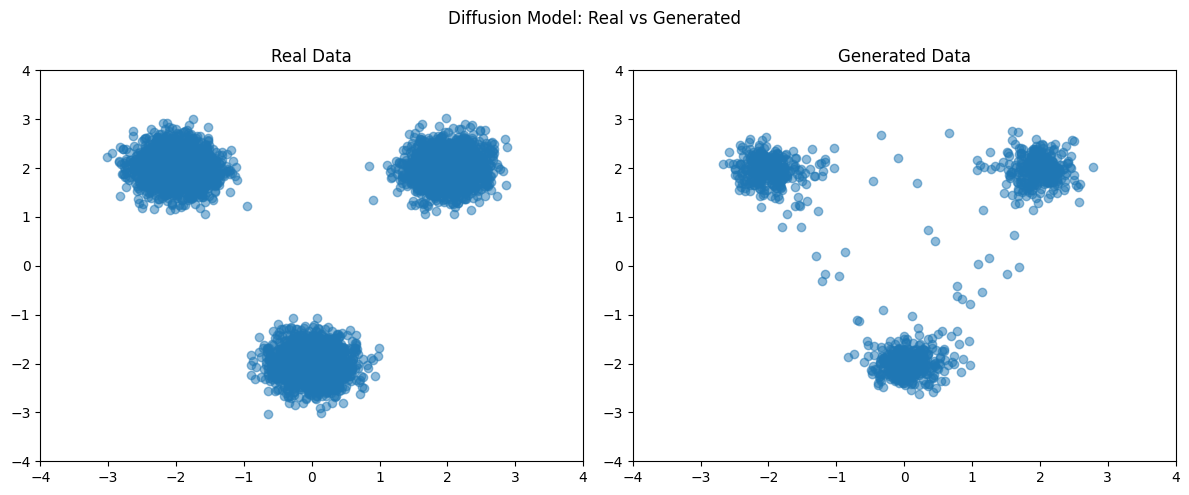

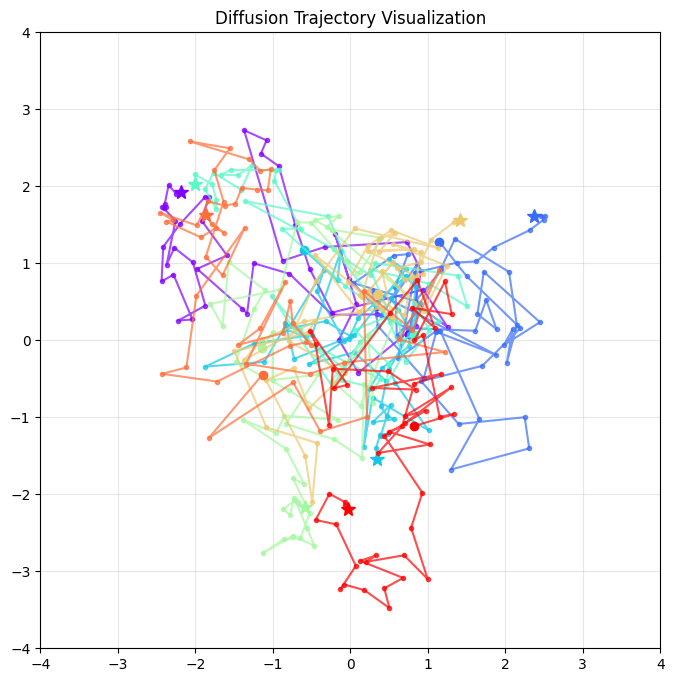

Generating diffusion snapshots: 1000it [00:00, 1907.98it/s]


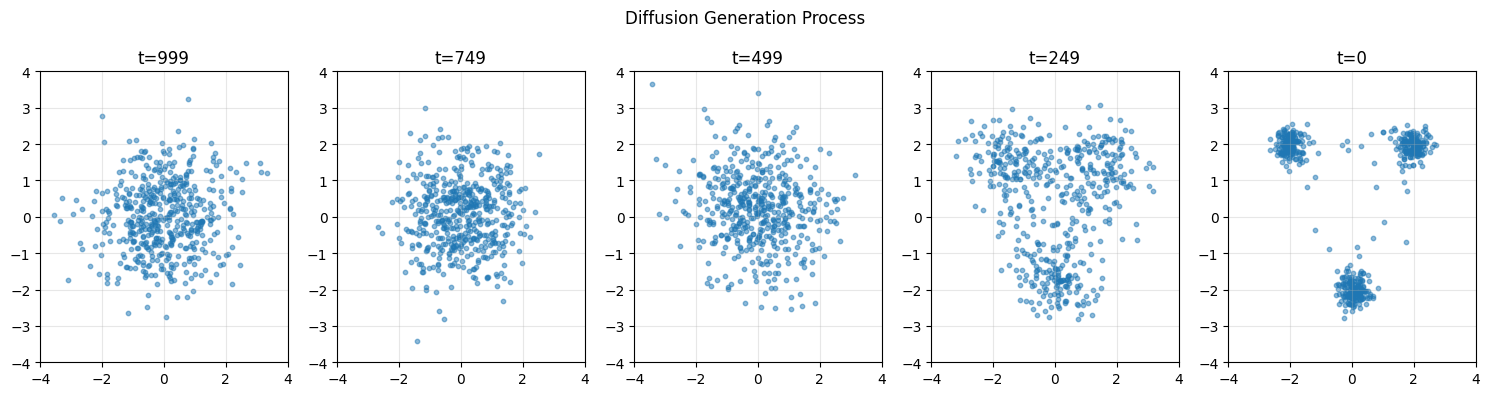

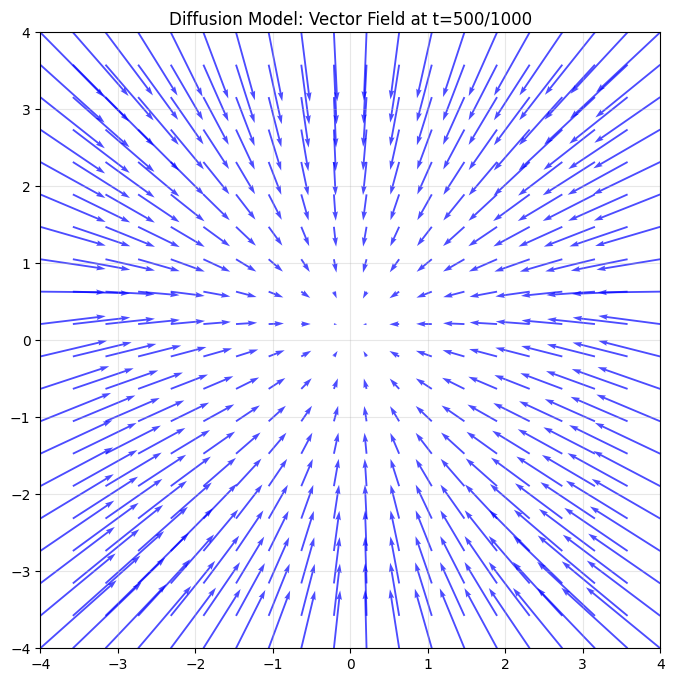

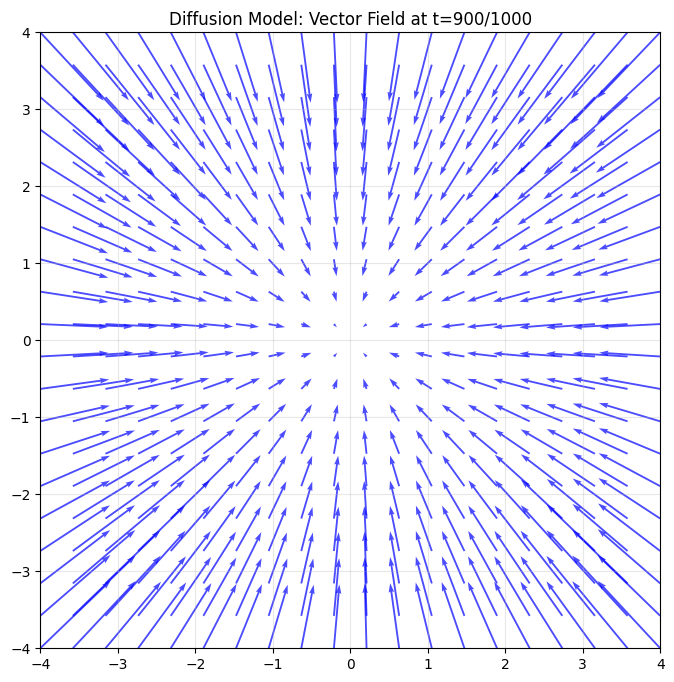

Generating diffusion frames: 100%|██████████| 1000/1000 [00:00<00:00, 1979.68it/s]



=== FLOW MATCHING DEMONSTRATION ===
Epoch 1/200 - Avg Loss: 4.427825
Epoch 2/200 - Avg Loss: 4.210405
Epoch 3/200 - Avg Loss: 3.812658
Epoch 4/200 - Avg Loss: 3.431797
Epoch 5/200 - Avg Loss: 3.298352
Epoch 6/200 - Avg Loss: 3.218901
Epoch 7/200 - Avg Loss: 3.264561
Epoch 8/200 - Avg Loss: 3.165851
Epoch 9/200 - Avg Loss: 3.230981
Epoch 10/200 - Avg Loss: 3.195242
Epoch 11/200 - Avg Loss: 3.154098
Epoch 12/200 - Avg Loss: 3.111846
Epoch 13/200 - Avg Loss: 3.257088
Epoch 14/200 - Avg Loss: 3.152087
Epoch 15/200 - Avg Loss: 3.077517
Epoch 16/200 - Avg Loss: 3.239045
Epoch 17/200 - Avg Loss: 3.254281
Epoch 18/200 - Avg Loss: 3.094449
Epoch 19/200 - Avg Loss: 3.047690
Epoch 20/200 - Avg Loss: 3.043398
Epoch 21/200 - Avg Loss: 3.056391
Epoch 22/200 - Avg Loss: 2.986638
Epoch 23/200 - Avg Loss: 3.074970
Epoch 24/200 - Avg Loss: 3.054497
Epoch 25/200 - Avg Loss: 2.973903
Epoch 26/200 - Avg Loss: 3.120631
Epoch 27/200 - Avg Loss: 2.983808
Epoch 28/200 - Avg Loss: 2.893782
Epoch 29/200 - Avg L

Sampling: 100%|██████████| 50/50 [00:00<00:00, 279.19it/s]


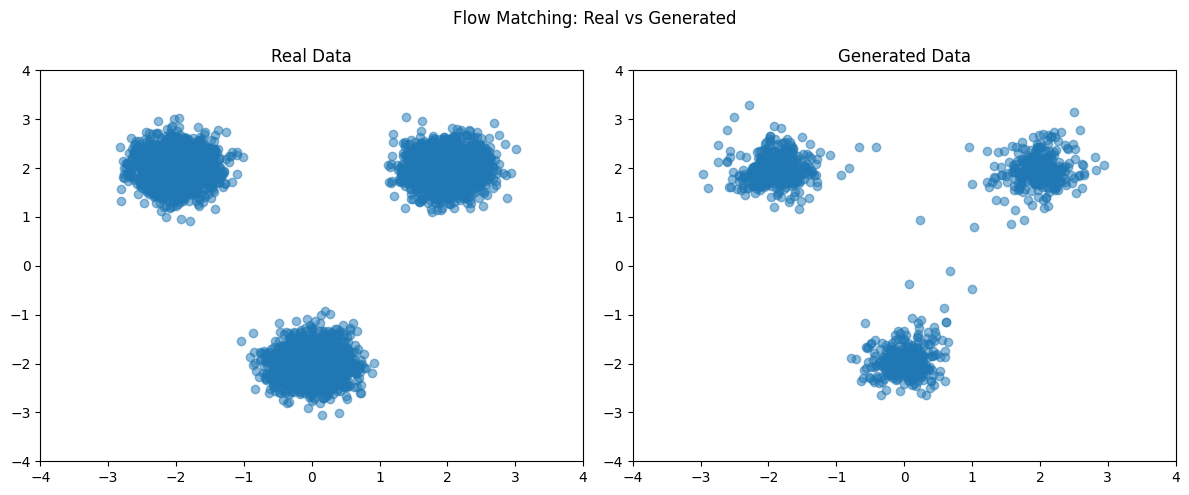

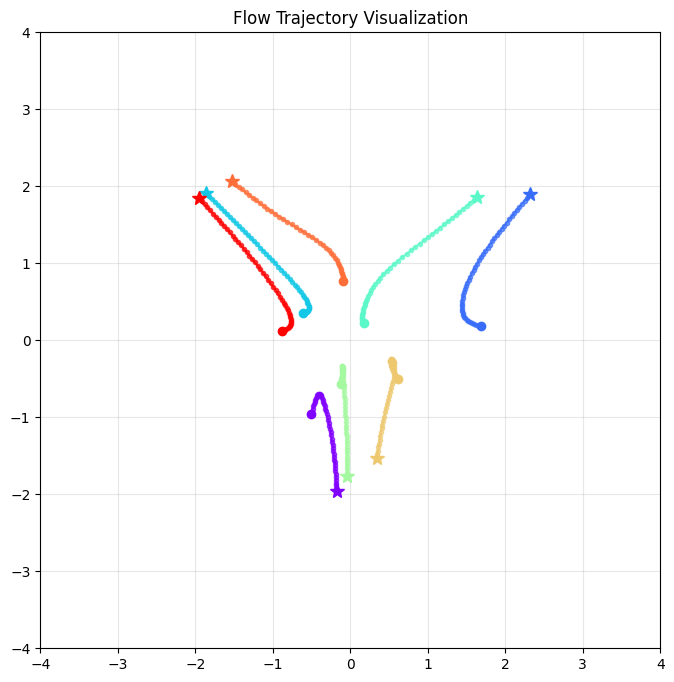

Generating flow matching snapshots: 100%|██████████| 50/50 [00:00<00:00, 3209.75it/s]


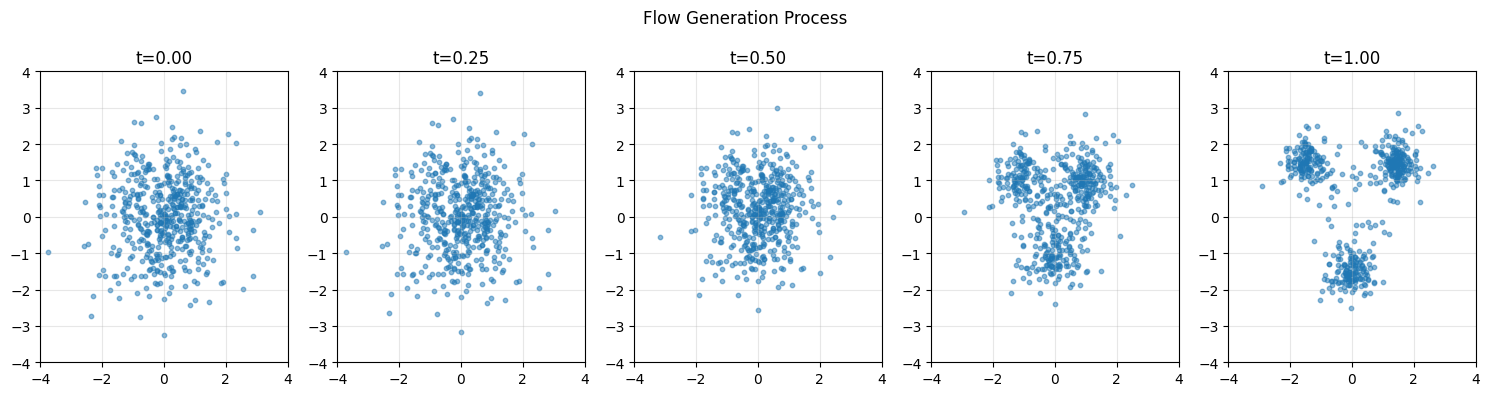

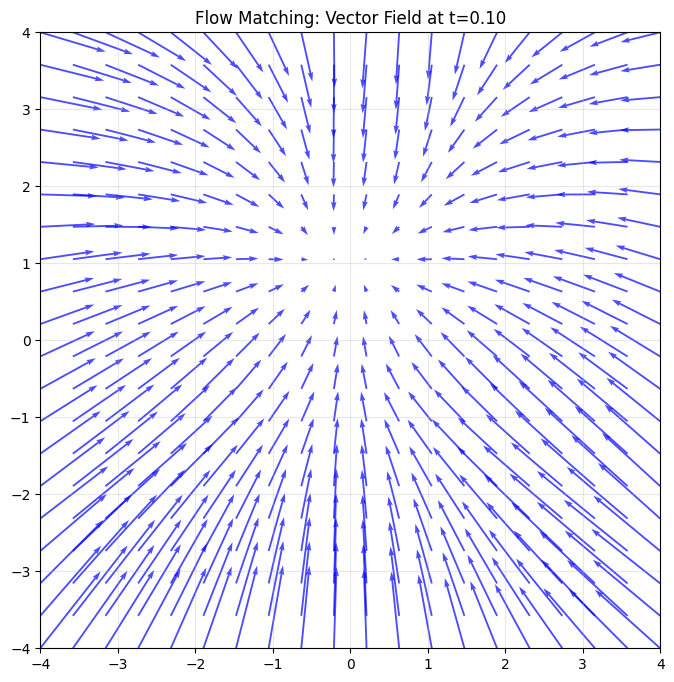

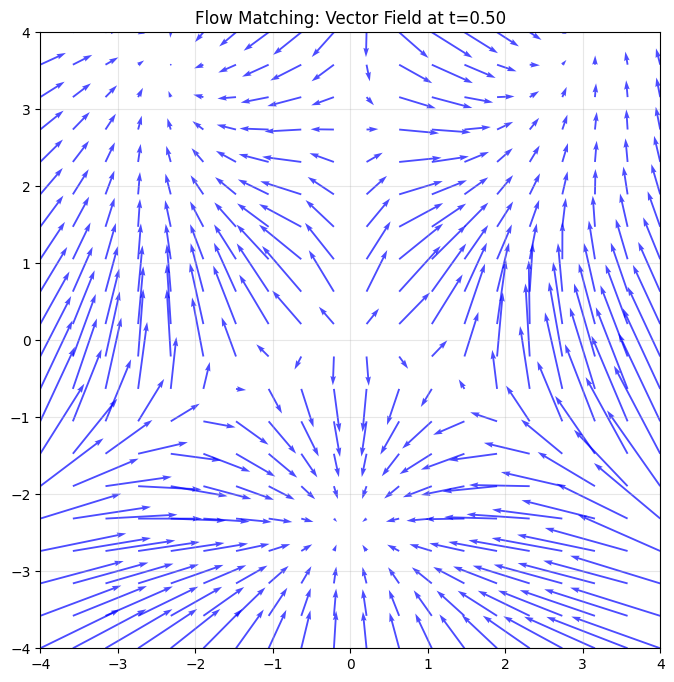

Generating flow matching frames: 100%|██████████| 50/50 [00:00<00:00, 2456.00it/s]
Generating diffusion frames: 1000it [00:00, 1979.31it/s]
Generating flow matching frames: 100%|██████████| 50/50 [00:00<00:00, 2830.66it/s]


(<__main__.DiffusionModel at 0x7bf951c76620>,
 <__main__.FlowMatching at 0x7bf912eaa6e0>)

In [11]:
run_comparison_demo()

In [ ]:
from IPython.display import Image
Image(url='./temp/diffusion_flowmatching/comparison_animation.gif')